# Customer Segmentation / Clustering

In [1]:
# Importing Pandas, numpy, matplot libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#Importing the Data
data = pd.read_csv('Wholesale customers data.csv')
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
Channel             440 non-null int64
Region              440 non-null int64
Fresh               440 non-null int64
Milk                440 non-null int64
Grocery             440 non-null int64
Frozen              440 non-null int64
Detergents_Paper    440 non-null int64
Delicassen          440 non-null int64
dtypes: int64(8)
memory usage: 27.6 KB


We see that we have this is a simple dataset with just eight features.

## EDA

Let's explore the data a bit

In [4]:
data_1 =data

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


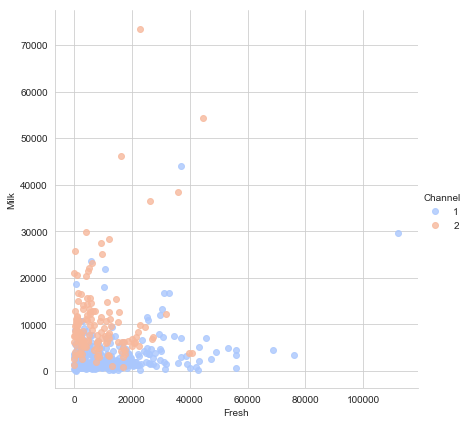

In [17]:
sns.set_style('whitegrid')
sns.lmplot('Fresh','Milk',data=data, hue='Channel',
           palette='coolwarm',size=6,aspect=1,fit_reg=False)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


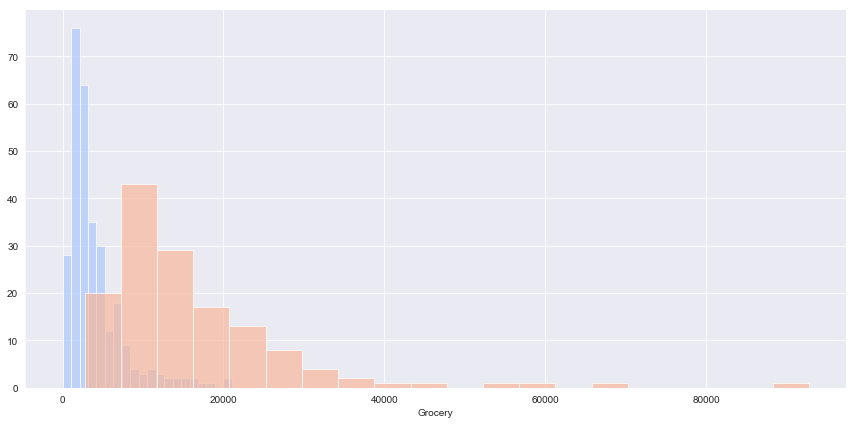

In [19]:
sns.set_style('darkgrid')
g = sns.FacetGrid(data,hue="Channel",palette='coolwarm',size=6,aspect=2)
g = g.map(plt.hist,'Grocery',bins=20,alpha=0.7)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


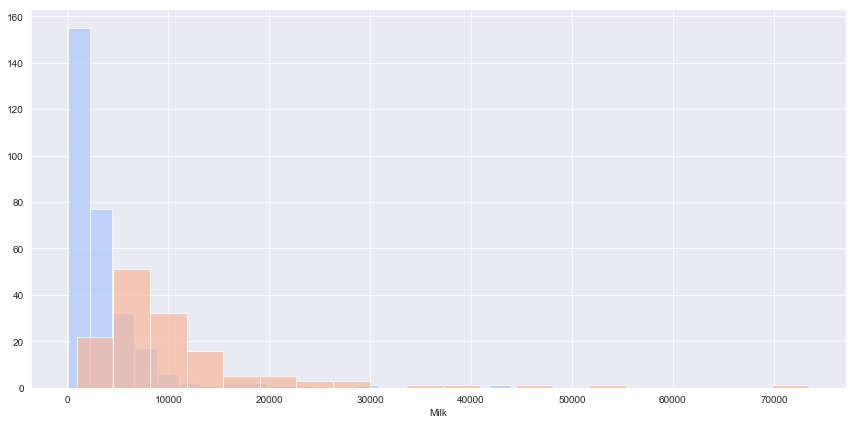

In [20]:
sns.set_style('darkgrid')
g = sns.FacetGrid(data,hue="Channel",palette='coolwarm',size=6,aspect=2)
g = g.map(plt.hist,'Milk',bins=20,alpha=0.7)

## Preparing the data

The first thing to note is that we are going to be using the Kmeans and Gaussian Mixture Model clustering algorithms, and comparing the results between them.
The Gaussian algorithm assumes a normal distribution, so it is important that we log normalize the data to fit it.
Also, both algorithms are based on distance, so we should scale the data.
We will employ the use of log transformation to achieve both these processes.

In [5]:
# Scale the data using the natural logarithm
log_data =np.log(data)

#View the log transformed data
log_data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.693147,1.098612,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931
1,0.693147,1.098612,8.861775,9.191158,9.166179,7.474205,8.099554,7.482119
2,0.693147,1.098612,8.756682,9.083416,8.946896,7.785305,8.165079,8.967504
3,0.000000,1.098612,9.492884,7.086738,8.347827,8.764678,6.228511,7.488853
4,0.693147,1.098612,10.026369,8.596004,8.881558,8.272571,7.482682,8.553525


We can also view the descriptive statistics of the data in order to see how it has scaled well below

In [6]:
log_data.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,0.223697,0.863044,8.730544,8.121047,8.441169,7.301396,6.785972,6.665133
std,0.324429,0.416749,1.480071,1.081365,1.116172,1.284540,1.721020,1.310832
min,0.000000,0.000000,1.098612,4.007333,1.098612,3.218876,1.098612,1.098612
25%,0.000000,0.693147,8.048059,7.334981,7.674616,6.609678,5.548101,6.011875
50%,0.000000,1.098612,9.048286,8.196159,8.467057,7.330388,6.705018,6.872645
75%,0.693147,1.098612,9.737064,8.880480,9.273854,8.175896,8.274341,7.506728
max,0.693147,1.098612,11.627601,11.205013,11.437986,11.016479,10.617099,10.777768


In [7]:
# Extreme Outlier detection 

'''
We will create a generic function to detect observations containing more than 1 outliers ie. 2 and above. 
'''

from collections import Counter
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than n outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from numerical variables
Outliers_to_drop = detect_outliers(log_data,1,log_data.columns.values)
# Show the outliers rows
log_data.loc[Outliers_to_drop]

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
203,0.000000,0.000000,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372
218,0.693147,0.000000,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
233,0.000000,0.000000,6.871091,8.513988,8.106515,6.842683,6.013715,1.945910
264,0.693147,0.000000,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
65,0.693147,1.098612,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,0.000000,1.098612,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
128,0.000000,1.098612,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
154,0.000000,1.098612,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
75,0.000000,1.098612,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437


In [8]:
#drop outliers

log_data = log_data.drop(Outliers_to_drop,axis=0).reset_index(drop=True)

We are going to confirm that the data is normalized by viewing their distributions as well as see their relationships via scatter plots.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


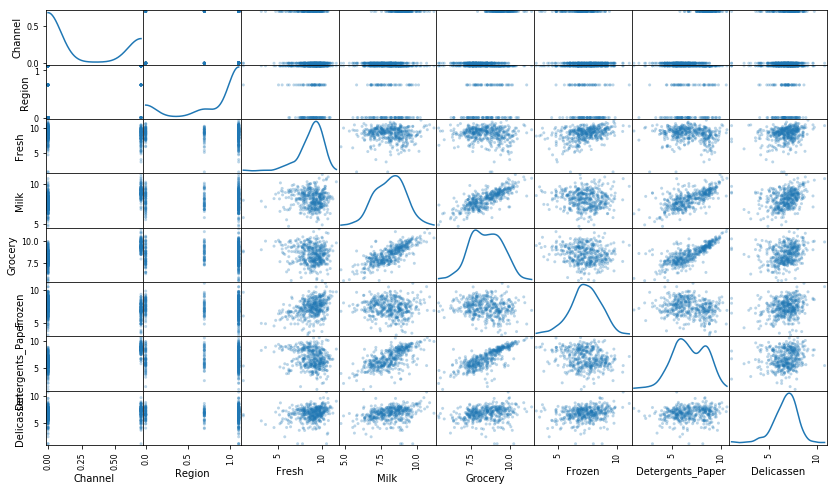

In [9]:
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

We can see that they are reasonably normalized.

Now we are ready for modelling

## Modelling¶ 

One of the challenges with clustering is that one cannot really determine the right number of clusters. Take for instance, you want to determine segments of customers, you cannot exactly know how many clusters or types of customers exist for a product, except in rare cases.
One way via which one can determine the right number of clusters is to use the Silhouette score analysis.

Another is called the Elbow Method
The most method however has its limitations.
We can also decide to try a different method for determining the optimal number of clusters, such as computing silhouette scores.

Ideally, it is advised that one should employ domain knowledge when determining the appropriate numbers of clusters. For instance, if you want to determine the right number of segments for a product, you have to consider your marketing ability / resources for each segment, the economic viability of having several segements and creating for each segment, the industrial standard segments, and so on. All of these should guide your cluster-number decisions.
However, we will explore the Elbow Method below, in order to determine the right number of clusters here.

## Elbow Method

Link (https://en.wikipedia.org/wiki/Elbow_method_(clustering))
The intuition behind the elbow criterion is to the run k-means clustering on the dataset for a range of values of cluster number, k, and for each value of cluster (k), we calculate the sum of squared errors (SSE).
We then plot a line chart of the SSE for each value of cluster (k). The point on the plot with the steepest decrease, that is where the plot looks like an elbow, is selected.
The whole idea is that we want a small SSE, but we also want one that tends to reduce as the value of k is increased. It is important to note that as the the value of k is increased, the SSE reduces and becomes 0 when the value of k = the number of data points. We want to try as much to avoid this, as this is kind of like overfitting.
Hence, the aim is to choose a small value of k that still provides us with a low SSE. The elbow joint is the best representation of this as it has the steepest descent, after which there is a diminishing reduce of SSE in increasing the value of k.
We will write a generic function to perform the elbow method.

k:  1
k:  2
k:  3
k:  4


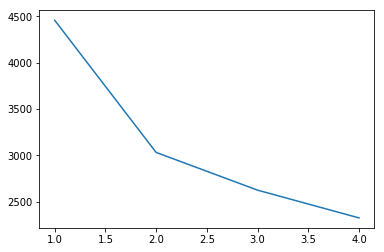

In [10]:
# Elbow criterion

#Impor Kmeans
from sklearn.cluster import KMeans

#write function

def elbow_plot(data, maxK=10, seed_centroids=None):
    """
        parameters:
        - data: pandas DataFrame (data to be fitted)
        - maxK (default = 10): integer (maximum number of clusters with which to run k-means)
        - seed_centroids (default = None ): float (initial value of centroids for k-means)
    """
    sse = {}
    for k in range(1, maxK):
        print("k: ", k)
        if seed_centroids is not None:
            seeds = seed_centroids.head(k)
            kmeans = KMeans(n_clusters=k, max_iter=500, n_init=100, random_state=0, init=np.reshape(seeds, (k,1))).fit(data)
            data["clusters"] = kmeans.labels_
        else:
            kmeans = KMeans(n_clusters=k, max_iter=300, n_init=100, random_state=0).fit(data)
            data["clusters"] = kmeans.labels_
        # Inertia: Sum of distances of samples to their closest cluster center
        sse[k] = kmeans.inertia_
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.show()
    return

elbow_plot(log_data, maxK=5)

We can see that the elbow occurs at 2, hence the best number of clusters should be 2
We will proceed to implement the Kmeans algorithm and view the clusters by features of three each

KMeans

In [11]:
from sklearn.cluster import KMeans

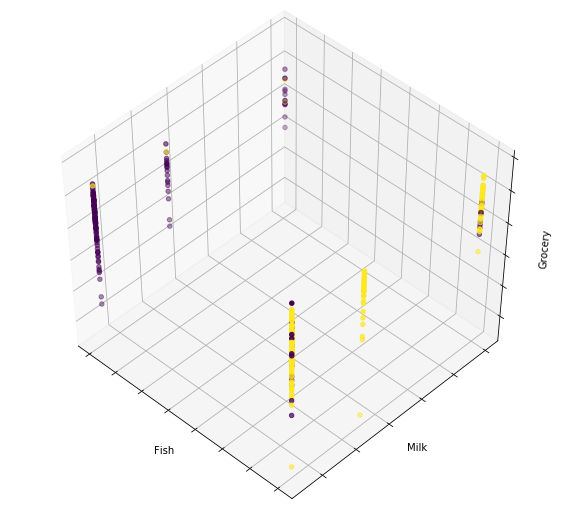

In [12]:
#Initialize clusterer

k_clusterer = KMeans(n_clusters=2)

#Fit a K-Means model to the data
k_clusterer.fit(log_data)

#perform predictions
k_preds = k_clusterer.predict(log_data)

#Get cluster centers
centers = k_clusterer.cluster_centers_

#Plot 3D scatter 

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 7))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)



ax.scatter(log_data.iloc[:, 0], log_data.iloc[:, 1], log_data.iloc[:, 2], c = k_preds)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Fish')
ax.set_ylabel('Milk')
ax.set_zlabel('Grocery')

plt.show()

Computing the average silhoutte score of the KMeans algorithm.
The silhouette coefficient for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar).
Hence, calculating the average silhouette score provides for a simple scoring method of a given clusterin

In [13]:
from sklearn.metrics import silhouette_score
silhouette_score(log_data, k_preds)

0.2971234391327145

Decent Score

We will now proceed to use the Gaussian Mixture Model
We will proceed to implement the algorithm and view the clusters by features of three each

GMM

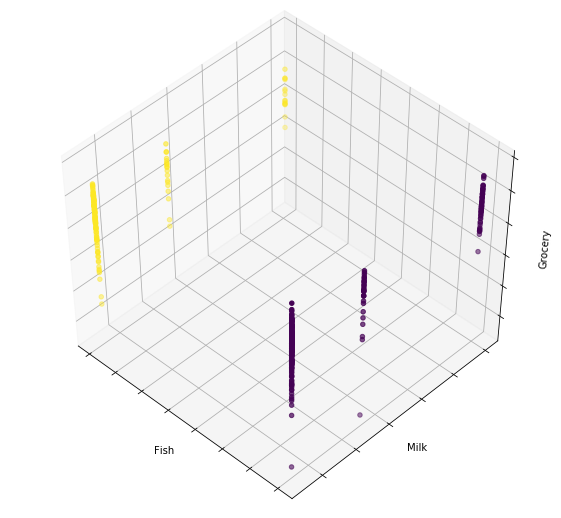

In [14]:
#Import GMM 
from sklearn.mixture import GaussianMixture
G_clusterer = GaussianMixture(2,random_state=123)

#Fit GMM to data
G_clusterer.fit(log_data)


#Predict the cluster for each data point
preds = G_clusterer.predict(log_data)

#Find the cluster centers
centers = G_clusterer.means_


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

fig = plt.figure(1, figsize=(8, 7))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)



ax.scatter(log_data.iloc[:, 0], log_data.iloc[:, 1], log_data.iloc[:, 2], c = preds)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Fish')
ax.set_ylabel('Milk')
ax.set_zlabel('Grocery')

plt.show()

In [15]:
from sklearn.metrics import silhouette_score
silhouette_score(log_data, preds)

0.2538852357407241

Again, we can see that the score is decent.

We will now apply PCA to the clustered data to visualize it with its clusters properly in 2D

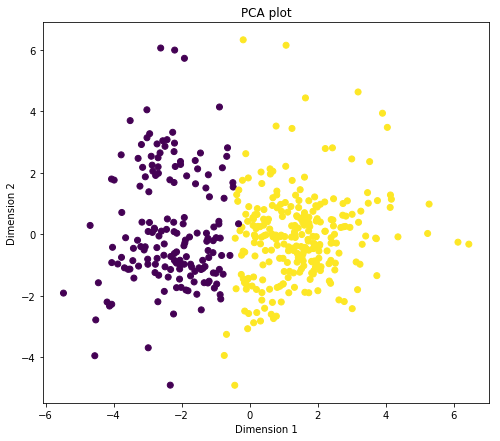

In [16]:
# Import PCA, specify number of dimensions, and Apply PCA by fitting the good data with only two dimensions

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(log_data)


# Transform the data using the PCA fit above
pca_data = pca.transform(log_data)

# Create a DataFrame for the PCA reduced data
pca_data = pd.DataFrame(pca_data, columns = ['Dimension 1', 'Dimension 2'])

fig = plt.figure(1, figsize=(8, 7))

plt.scatter(pca_data.iloc[:, 0], pca_data.iloc[:, 1], c = k_preds)

plt.title('PCA plot')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.show()